In [2]:
import numpy as np
from smt.surrogate_models import KRG
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


In [3]:
# Load data
df = pd.read_csv('Monte_Carlo_10000/training_data_crushing.csv')

In [4]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = df[['mean_force']].values

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [6]:
poly_values = ['constant', 'linear', 'quadratic']
corr_values = ['pow_exp', 'abs_exp', 'squar_exp', 'matern52', 'matern32']

In [7]:
values = []
for ploy in poly_values:
    for corr in corr_values:
        KRG_model = KRG(
            corr=corr,
            poly=ploy, 
            print_global=False
        )
        KRG_model.set_training_values(X_train, Y_train)
        KRG_model.train()
        Y_pred = KRG_model.predict_values(X_val)
        mape = mean_absolute_percentage_error(Y_val, Y_pred)
        values.append([ploy, corr, mape*100])

values = np.array(values)
hyperparameters = pd.DataFrame(values, columns=['poly', 'corr', 'mape'])
min_mse = hyperparameters['mape'].min()
print("MAPE, for KRG:", format(round(float(min_mse), 4),'.2f'), "%")
print("Corr:", hyperparameters['corr'][hyperparameters['mape'].idxmin()])
print("Poly:", hyperparameters['poly'][hyperparameters['mape'].idxmin()])

# Convert 'mape' to a numeric type to ensure correct handling
hyperparameters['mape'] = pd.to_numeric(hyperparameters['mape'], errors='coerce')

# Pivot to reshape the DataFrame for the heatmap
pivot_df = hyperparameters.pivot(index='corr', columns='poly', values='mape')
    

MAPE, for KRG: 0.67 %
Corr: abs_exp
Poly: linear


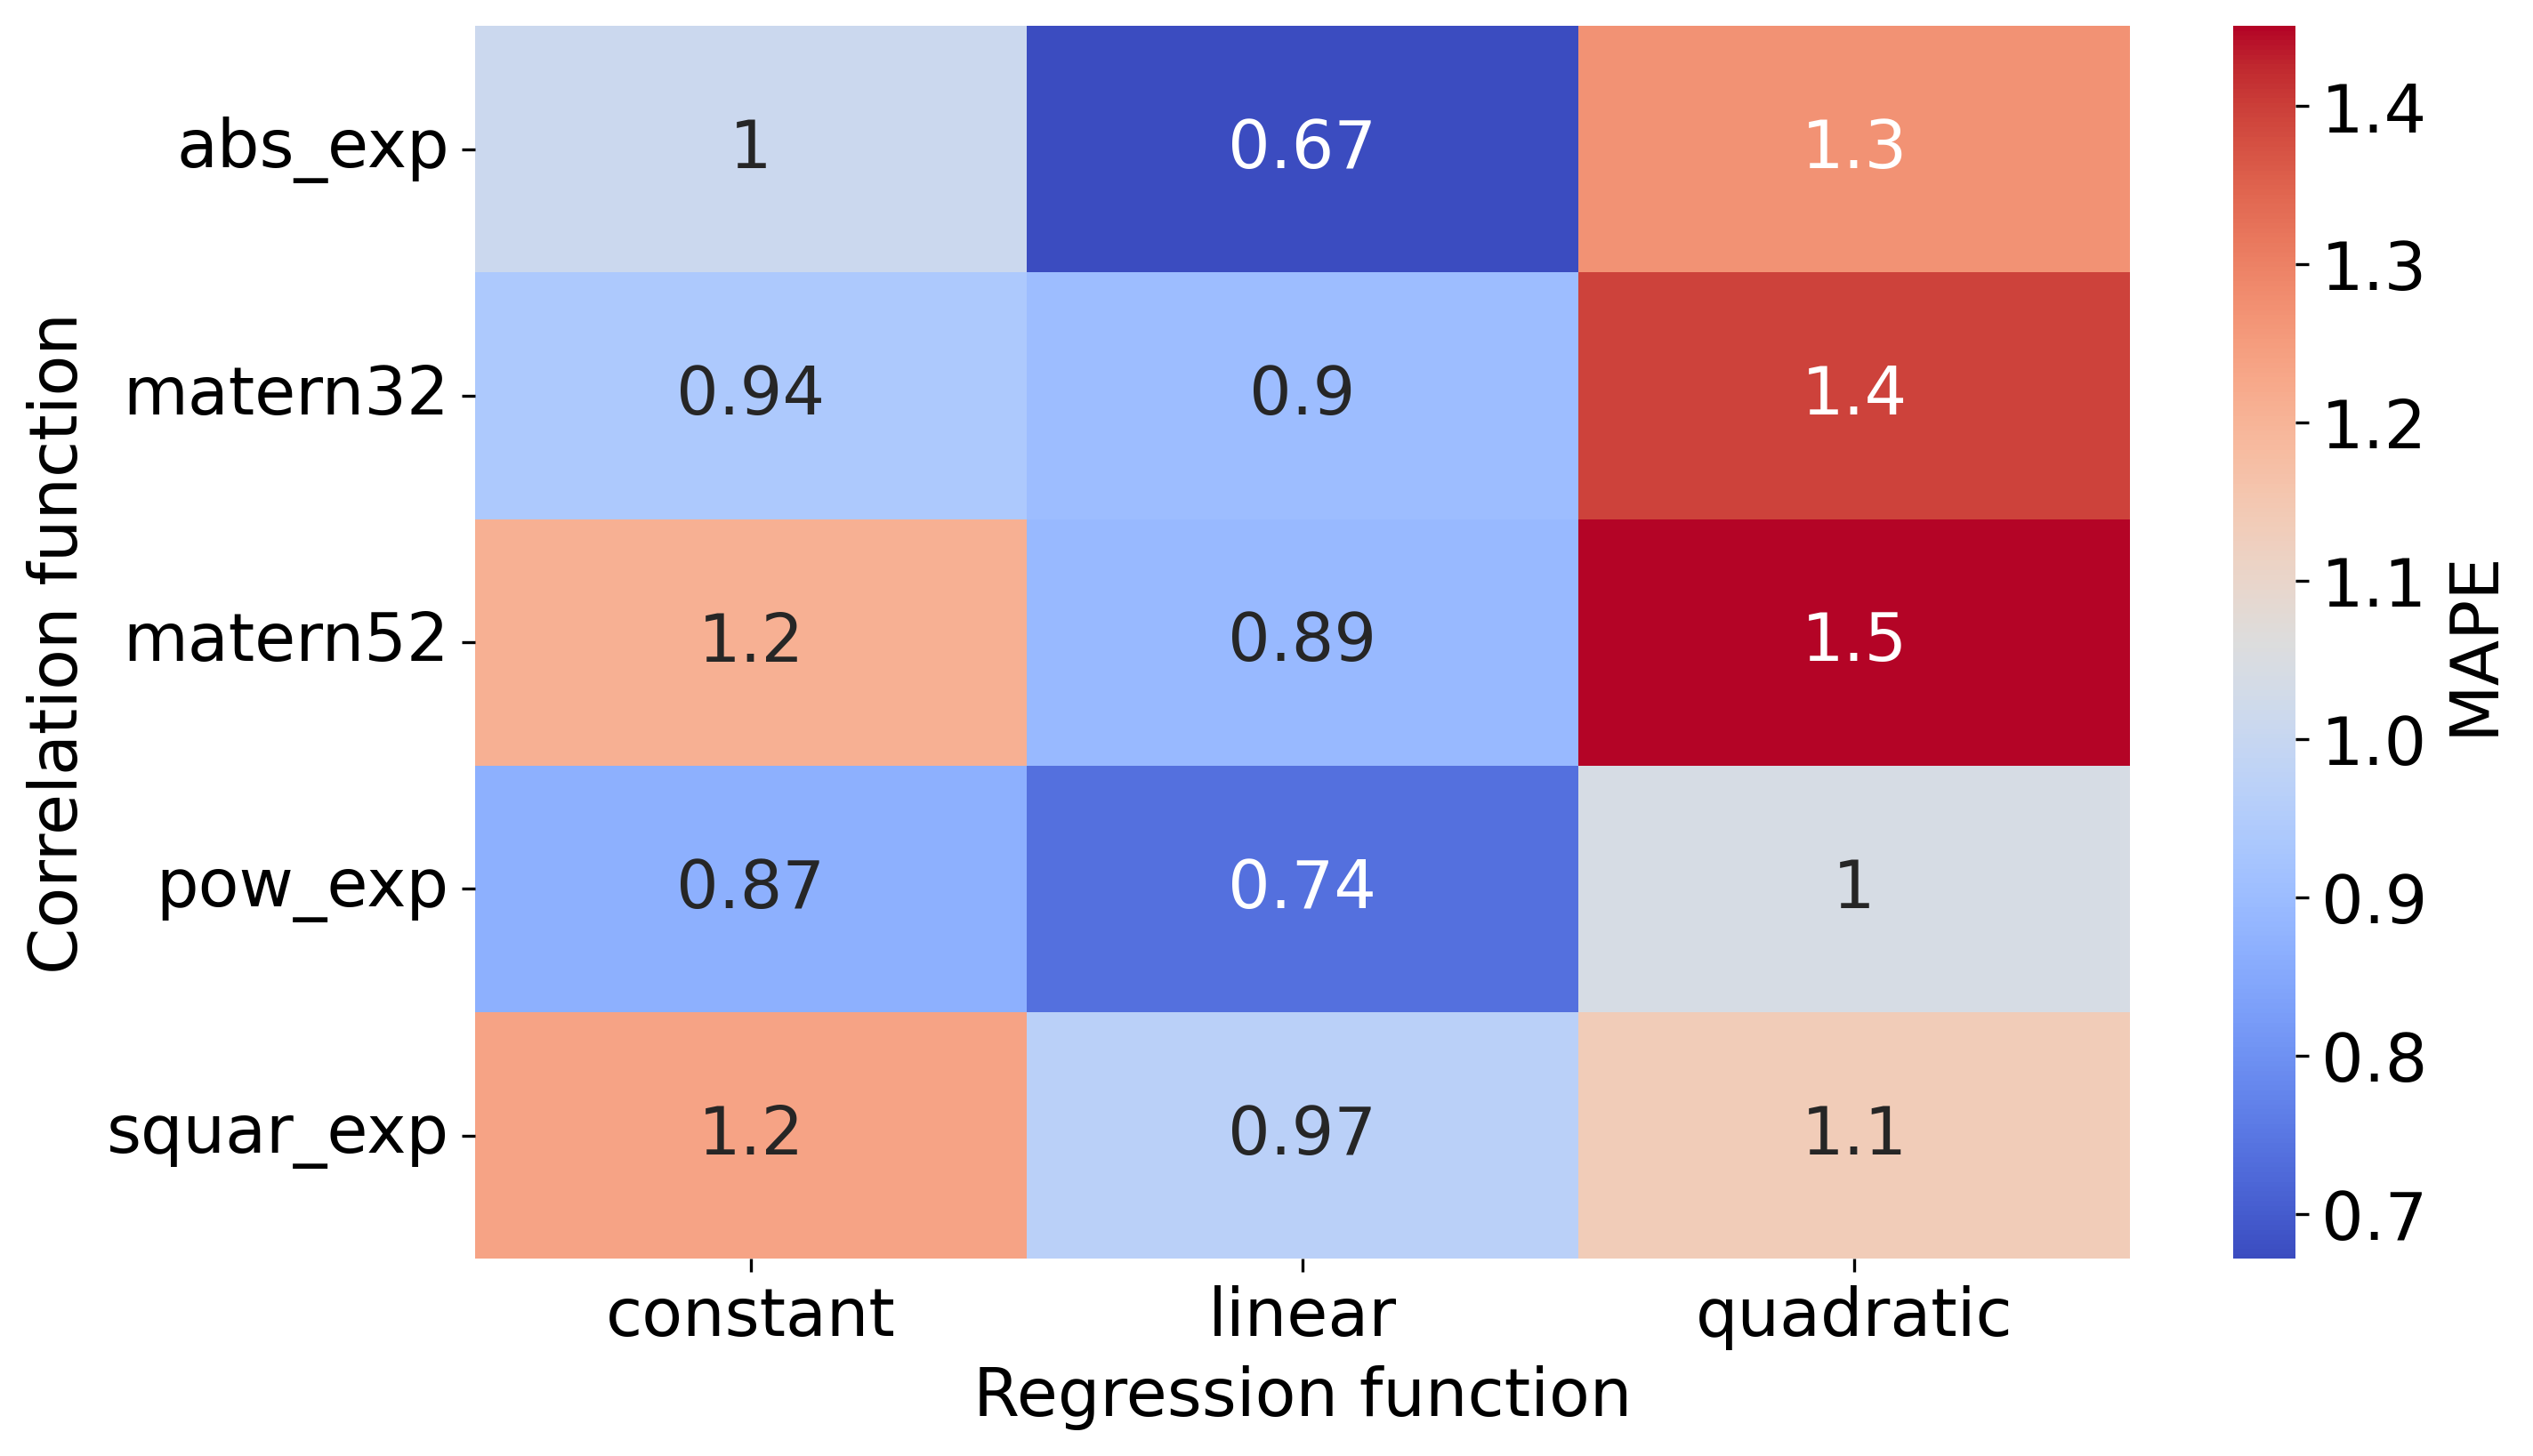

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `pivot_df` is your DataFrame containing the heatmap data
plt.figure(figsize=(10, 6), dpi=300)
heatmap = sns.heatmap(
    pivot_df,
    annot=True,
    annot_kws={"fontsize": 18},  # Set font size for annotation numbers
    cmap='coolwarm',
    cbar_kws={'label': 'MAPE'},  # Set only the colorbar label
)
plt.xlabel('Regression function', fontsize=18)  # Set font size for x-axis label
plt.ylabel('Correlation function', fontsize=18)  # Set font size for y-axis label
plt.xticks(fontsize=18)  # Set font size for x-tick labels
plt.yticks(fontsize=18, rotation=0)  # Set font size for y-tick labels

# Access the colorbar from the heatmap object
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=18)  # Adjust the colorbar tick labels font size
colorbar.set_label('MAPE', size=18)  # Adjust the colorbar label size

plt.show()



In [9]:
# Best hyperparameters
KRG_model = KRG(
    corr= hyperparameters['corr'][hyperparameters['mape'].idxmin()],
    poly= hyperparameters['poly'][hyperparameters['mape'].idxmin()], 
    print_global=False
)
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()
Y_pred = KRG_model.predict_values(X_val)
mape = mean_absolute_percentage_error(Y_val, Y_pred)
print("MAPE, for KRG:", format(round(float(mape), 4)*100,'.2f'), "%")
mape_KRG_train = mean_absolute_percentage_error(Y_train, KRG_model.predict_values(X_train))
print("MAPE for training data, for KRG:", format(round(mape_KRG_train, 4)*100,'.2f'), "%")

MAPE, for KRG: 0.67 %
MAPE for training data, for KRG: 0.00 %


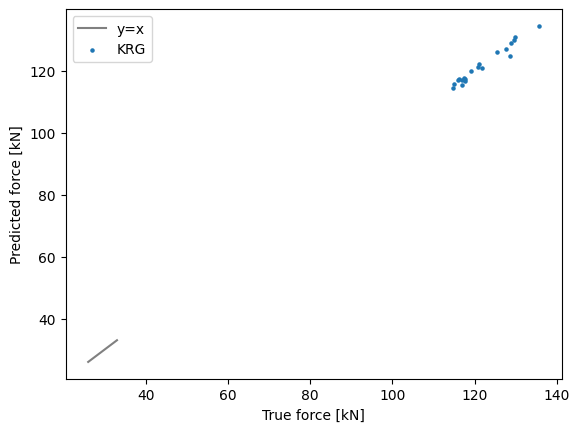

In [10]:
plt.plot([26,33], [26, 33], label='y=x', color='gray')

plt.scatter(Y_val, Y_pred, s=5, label='KRG', color='tab:blue')

plt.xlabel('True force [kN]')
plt.ylabel('Predicted force [kN]')
plt.legend()